In [1]:
import path_configs # noqa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from datetime import datetime
def read_TFRecord(input_shape: dict,
                  output_shape: dict,
                  parallel_load: int,
                  path_to_file: str):
    """
    Method for reading .tfrecord file into TFRecordDataset object.
    :param input_shape: input_shape of dataset
    :param output_shape: output_shape of dataset
    :param batch_size: batch size
    :param parallel_load: number of parallel loading threads
    :return: TFRecordDataset object
    """
    featdef = dict()
    for key in input_shape.keys():
        featdef[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.string)
    for key in output_shape.keys():
        featdef[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.string)
    def _parse_record(example_proto):
        """Parse a single record into image, weather labels, ground labels"""
        example = tf.io.parse_single_example(example_proto, featdef)
        x_dict = dict()
        for x_key in [k for k in example.keys() if 'x' in k]:
            data = tf.io.decode_raw(example[x_key], tf.float32)
            x_dict[x_key] = tf.reshape(data, input_shape[x_key])
        y_dict = dict()
        for y_key in [k for k in example.keys() if 'y' in k]:
            data = tf.io.decode_raw(example[y_key], tf.float32)
            y_dict[y_key] = tf.reshape(data, output_shape[y_key])
        return x_dict, y_dict
    dset = tf.data.TFRecordDataset(path_to_file, compression_type='ZLIB')
    dset = dset.map(_parse_record, num_parallel_calls=parallel_load)
    return dset


In [2]:
time_steps = 128
n_features = 128
latent_dims = 32

def encoder(x):
    x = tf.keras.layers.LSTM(n_features//2, activation='tanh', return_sequences=True)(x)
    x = tf.keras.layers.LSTM(latent_dims, activation='tanh')(x)
    return x

def decoder(x):
    x = tf.keras.layers.RepeatVector(n_features)(x)
    x = tf.keras.layers.LSTM(n_features//2, activation='tanh', return_sequences=True)(x)
    x = tf.keras.layers.LSTM(n_features, return_sequences=True)(x)
    return x

def autoencoder():
    input = tf.keras.layers.Input(shape=(time_steps, n_features))
    encoded = encoder(input)
    decoded = decoder(encoded)
    return tf.keras.models.Model(inputs=input, outputs=decoded)

model = autoencoder()
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse'])

In [3]:
train_set_length = 356456 
val_set_length = 89038
"""know lengths"""
batch_size = 64
epochs = 30
steps_per_epoch = train_set_length//batch_size
validation_steps = val_set_length//batch_size

x_size_dict = {'x': [128, 128, 1], 'x_mfcc':[40, 128, 1]}
y_size_dict = {'y_age':[1], 'y_gender':[1]}
dataset_train = read_TFRecord(x_size_dict, y_size_dict, 2, os.path.join('data', 'tf_record', 'data_train.tfrecord'))
dataset_val = read_TFRecord(x_size_dict, y_size_dict, 2, os.path.join('data', 'tf_record', 'data_val.tfrecord'))

# def scaled(tensor, y):
#     return (tensor-tf.math.reduce_min(tensor))/(tf.math.reduce_max(tensor)-tf.
#                                                 math.reduce_min(tensor)), y1
def scale(x, y):
    max_x = (x['x']-tf.math.reduce_min(x['x']))/(30-tf.math.reduce_min(x['x']))
    max_x_mfcc = (x['x_mfcc']-tf.math.reduce_min(x['x_mfcc']))/(400-tf.math.reduce_min(x['x_mfcc']))
    return {'x':max_x, 'x_mfcc':max_x_mfcc}, y


def make_self_feedback(x, y):
    return x['x'], x['x']


def preprocess_dataset(dataset, batch_size):
    dataset = dataset.map(scale)
    dataset = dataset.map(make_self_feedback)
    dataset = dataset.shuffle(buffer_size=train_set_length//50, seed=666, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)    
    dataset = dataset.prefetch(buffer_size=5)
    dataset = dataset.repeat(count=-1)
    return dataset

dataset_train = preprocess_dataset(dataset_train, batch_size)
dataset_val = preprocess_dataset(dataset_val, batch_size)

In [6]:
now = datetime.now()
date_time = now.strftime("%m_%d_%Y_%H_%M")
NAME = ("autoencode_model_log" + date_time)
log_dir = log_dir=os.path.join('logs', str(NAME))

callbacks = [tf.keras.callbacks.TensorBoard(log_dir),
             tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('saved_models', 'checkpoints','{}.h5'.format(NAME)),
                                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
with tf.device('/device:GPU:0'):
    model.fit(
        dataset_train,
        steps_per_epoch = steps_per_epoch,
        epochs = epochs,
        verbose = 1,
        validation_data = dataset_val,
        validation_steps = validation_steps,
        callbacks=callbacks
        )

Epoch 1/30
   1/5569 [..............................] - ETA: 0s - loss: 0.1126 - mae: 0.2476 - mse: 0.1126WARNING:tensorflow:From C:\Users\skaya\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5567/5569 [============================>.] - ETA: 0s - loss: 0.0175 - mae: 0.0967 - mse: 0.0175
Epoch 00001: val_loss improved from inf to 0.01322, saving model to saved_models\checkpoints\autoencode_model_log12_02_2020_12_46.h5
5569/5569 [==============================] - 299s 54ms/step - loss: 0.0175 - mae: 0.0966 - mse: 0.0175 - val_loss: 0.0132 - val_mae: 0.0830 - val_mse: 0.0132
Epoch 2/30
5569/5569 [==============================] - ETA: 0s - loss: 0.0115 - mae: 0.0765 - mse: 0.0115
Epoch 00002: val_loss improved from 0.01322 to 0.01015, saving model to saved_models\checkpoints\aut

In [4]:
model = tf.keras.models.load_model(r'saved_models\checkpoints\autoencode_model_log12_03_2020_04_27.h5')

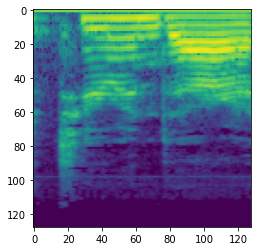

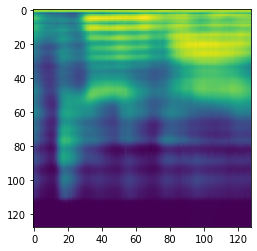

In [6]:
for x,x in dataset_val.take(1):
    data = x

prd = model.predict(x)

plt.imshow(data[0,:,:,0])
plt.show()

plt.imshow(prd[0,:,:])
plt.show()

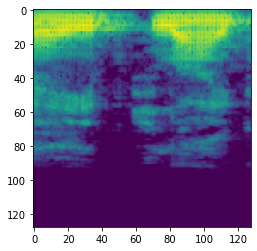

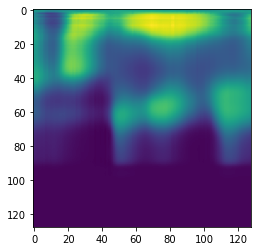

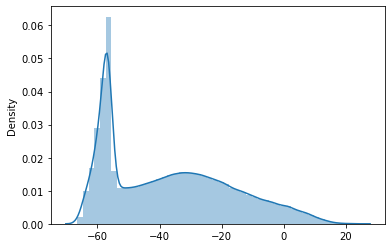

In [23]:
import seaborn as sns
for x, x in dataset_train.take(1):
    sns.distplot(x)

In [29]:
from tqdm import tqdm
max = 0
max_mfcc = 0
for x, y in tqdm(dataset_train.take(500)):
    if np.max(x['x'])>max:
        max=np.max(x['x'])
    if np.max(x['x_mfcc'])>max_mfcc:
        max_mfcc=np.max(x['x_mfcc'])

100%|██████████| 500/500 [00:33<00:00, 14.87it/s]


In [30]:
max

26.641302

In [31]:
max_mfcc

324.38605